In [1]:
library(IRdisplay)

display_html(
'<script>  
code_show=true; 
function code_toggle() {
  if (code_show){
    $(\'div.input\').hide();
  } else {
    $(\'div.input\').show();
  }
  code_show = !code_show
}  
$( document ).ready(code_toggle);
</script>
  <form action="javascript:code_toggle()">
    <input type="submit" value="Click here to toggle on/off the raw code.">
 </form>'
)

In [3]:
library(brms)
library(haven) # to load the SPSS .sav file
library(tidyverse) # needed for data manipulation.
library(RColorBrewer) # needed for some extra colours in one of the graphs
library(ggmcmc)
library(ggthemes)
library(ggridges)

# IMPORT VISUALIZATION LIBRARIES:
library(data.table)
library(ggplot2)
library(ggridges)
library(dplyr)
library(tidyr)
library(scales)
library(viridis)

In [4]:
plotPDP <- function(fm){
    data <- fixef(fm,summary = FALSE)
    rois <- colnames(data)
    nobj=dim(data)[1]
    data_stats = data.frame(1:length(rois))
    # create ROI column instead of numerics to match threat table above

    data_stats$ROI <- rois
    data_stats$mean <- colMeans(data)
    data_stats$P <- colSums(data > 0)/nobj
    data_stats$Pn <- data_stats$P

    for (i in 1:length(rois)) {
      if (data_stats$P[i]<.5){data_stats$Pn[i]=1-data_stats$P[i]}
    }


    # this will order the distributions correctly
    data_stats <- data_stats[order(data_stats$mean),]



    data_trans <- as.data.frame(t(as.matrix(data)))
    data_trans <- tibble::rownames_to_column(data_trans, "ROI")
    data_trans$X <- 1:nrow(data_trans)

    # merge values & stats into one table by ROI

    data_merge <- merge(data_stats, data_trans, by = "ROI")
    data_merge <- data_merge[order(data_merge$X),]

    # Transform data into long form


    # Melt dataframe by ROI
    library(data.table)

    data_long <- melt(data_trans, id=c("ROI","X"))

    data_long <- data_long[order(data_long$X),]


    # This is incredibly clunky, but for the sake of time adding stats by ensuring orders are all the same and repeating each value 2000 times... Tried a few different methods with no success for some reason. 

    data_long$mean <- rep(data_merge$mean, each = nobj)
    data_long$P <- rep(data_merge$P, each =nobj)
    data_long$Pn <- rep(data_merge$Pn, each =nobj)
    # set your labels here so you don't have to change within the plot below: 
    format(round(1, 2), nsmall = 3)

    y.axis.labs <- format(round(data_stats$P,3), nsmall = 3)                        # y axis labels
    sec.y.axis.labs <- data_stats$ROI                             # second y axis labels (probabilities)


     # X AXIS LABELS NEED TO CHANGE TO CORRESPOND TO DATA SET! UNCOMMENT WHICHEVER MATCHES

    # Uncomment for THREAT
    x.axis.labs <- c( "control > uncontrol", "0", "uncontrol > control")                 # x axis labels  THREAT
    x.labs.pos <- c(-0.25, 0, 0.25)                                             # x axis position THREAT


    # Uncomment for VALENCE
    #x.axis.labs <- c("Neutral > Positive", "0", "Positive > Neutral")         # x axis labels  VALENCE
    #x.labs.pos  <- c(-0.1,0,0.2)                                              # x axis position VALENCE

    # Uncomment for INTERACTION
    #x.axis.labs <- NULL                                                       # x axis labels  INTERACTION, not sure what to put.
    #x.labs.pos <- NULL                                                        # a axis position INTERACTION, change when labels decided

    #graph.title <- data.name                                   # graph title 
    legend.title <- "Probability"                              # legend title
    y.axis.title <- NULL                                       # for now ...
    x.axis.title <- NULL                                       # for now...

    # GRAPH DATA
    # GRAPH DATA
    library(repr)
    options(repr.plot.width=8,repr.plot.height=4)

    dataset <- data_long
    x.values <- data_long$value                               # x values
    y.values <- data_long$ROI                                 # y values
    y.values.RO <- data_long$value                            # values to reorder Y by
    distrib.fill <- data_long$Pn                              # fill graph with probabilities
    group <- data_long$ROI

    # Other aspects
    gradient.colors <- c("yellow","#C9182B","#41245C")        # change gradient colors here (currently, yellow - purple)
    label.size <- 16                                         # adjust ROI and probability y-axis font size
    title.size <- 32                                          # adjust graph title size 
    x.axis.size <- 16                                        # adjust x-axis label sizes

    # here is where you can change information about the graph and add other characteristics using ggplot and ggridges


    ggplot(dataset, aes(x = x.values, y = as.numeric(reorder(y.values, y.values.RO)), 
                        fill = distrib.fill, group = group)) +                        # scale = spacing, alpha = transparency
      coord_cartesian(xlim = c(-0.5, 0.5)) +
      stat_density_ridges(quantile_lines = TRUE, 
                          quantiles = 2, 
                          alpha = .95, 
                          scale = 1,
                          color = "black",
                          size = .35
                         ) +            # divide into two quantiles (show mean)
      geom_vline(xintercept = 0, linetype="solid",color = "black",alpha = .95, size = .45) +    #create line at X = 0
      scale_fill_gradientn(colors = viridis_pal(direction = 1, option = "inferno")(20),                         # set gradient
                           limits = c(.85,1),                                # which probabilites matter?
                           na.value = "#909497",                                # if not in limits, gray out
                           name = legend.title) +                            # name legend
      scale_y_continuous(breaks = 1:length(rois),                            # A VERY HACK-Y WAY TO HAVE TWO Y AXES W DISCRETE DATA
                         expand = c(0,0),
                         labels = y.axis.labs,                               # Trick ggplot into thinking data is continuous...
                         sec.axis = sec_axis(~.,                             # Second axis to show probabilities
                                             breaks = 1:length(rois),
                                             labels = sec.y.axis.labs)) +
      #theme_ridges(font_size = label.size, grid = TRUE, center_axis_labels = TRUE) +  # theme info
      #ggtitle(graph.title)+ 
      #theme_bw() +# graph title
     #theme_ridges(grid = FALSE) + 
      theme(   
        panel.background = element_blank(),
        legend.position = "none",
        #panel.grid.major.y = element_line(color = "grey"), 
        plot.title = element_text(hjust = 0.5, size = title.size),            # plot title size and position
        axis.text.y = element_text(size=label.size),                               # y-axis text size
        axis.line.x = element_line(color = "gray"),
        axis.text.y.right = element_text(size = label.size),                  # y-axis info for right axis
        axis.text.x = element_text(size = x.axis.size),
        #plot.margin = unit(c(0,0,0,0), "cm"),
        axis.ticks.x = element_blank(),
        axis.ticks.y = element_blank(),
        legend.title.align = 5)+
      guides(shape = guide_legend(label.position = "bottom",
                                  title.positon = "bottom",
                                  title.vjust = 0.4)) +          
      labs(
        x = NULL,                                                         # Add or not add X and Y labels
        y = NULL) +
      scale_x_continuous(breaks = x.labs.pos, labels = c(x.axis.labs))
}

# **ROI and SCR correlation difference**

## **Model**

$$Y \sim student\_t(\nu,\mu,\sigma^{2}_{\epsilon})$$
$$\mu = \beta_{0} + \beta_{TM}TM + \beta_{TD}TD + \beta_{SM}SM + \beta_{SD}SD + \beta_{BPD}BPD + \epsilon$$

$Y = z[corr(ROI_{uncon},SCR_{uncon})] - z[corr(ROI_{con},SCR_{con})]$  
ROI: ROI trial-by-trial (TBT) betas  
SCR: skin conductance TBT betas  
TM: Trait mean  
TD: Trait difference (uncon-con)  
SM: State mean  
SD: State difference (uncon-con)  

## **Priors**
$$\beta_{0} \sim student\_t(3,0,10)$$
$$\nu \sim \Gamma(3.325,0.1)$$
$$\sigma_{\epsilon} \sim student\_t(3,0,10)$$

In [24]:
df <- read.table('uncon_v_con_shock_MR_ROI24final_with_covariates.txt',header = TRUE,sep='\t')
dataTable <- distinct(select(df,-ROI,-Y))

In [25]:
head(dataTable)

,Subj,TRAITmean,TRAITdiff,STATEmean,STATEdiff,BPdiff_stdz
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,P00,-1.0030,-0.0406,-1.2307,-0.1812,-0.8664
2,P01,-0.4359,3.1472,-0.4379,0.4163,0.3736
3,P02,0.1942,0.3136,-0.5172,0.3167,-0.3028
4,P03,-1.5702,1.0220,-1.6270,-0.0816,0.3360
5,P04,-0.2469,-0.0406,-0.2794,0.6155,-0.7913
6,P05,0.2572,-0.0406,0.3548,-0.5795,-0.1900


## **Trait (uncon-con)**

In [29]:
mod = '1'
modelForm = paste('TRAITdiff ~',mod)
priorRBA <- get_prior(formula = modelForm,data=dataTable,family = 'student')
priorRBA$prior[2] <- "gamma(3.325,0.1)"
priorRBA

,prior,class,coef,group,resp,dpar,nlpar,bound
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,"student_t(3, 0, 10)",Intercept,,,,,,
2,"gamma(3.325,0.1)",nu,,,,,,
3,"student_t(3, 0, 10)",sigma,,,,,,


In [30]:
iterations <- 10000
chains <- 4
SCALE <- 1
ns <- iterations*chains/2

EOI = 'Intercept'

# number of ROIs
nR <- nlevels(dataTable$ROI)

# number of sigfigs to show on the table
nfigs <- 4

In [32]:
trait <- brm(modelForm,
          data=dataTable,
          chains = chains,
          family = 'student',
          prior = priorRBA,
          inits=0, iter=iterations, 
          control = list(adapt_delta = 0.99, max_treedepth = 15))

Compiling the C++ model

Start sampling




SAMPLING FOR MODEL '204d3641dcffa1b885f9f2679fb9528e' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 10000 [  0%]  (Warmup)
Chain 1: Iteration: 1000 / 10000 [ 10%]  (Warmup)
Chain 1: Iteration: 2000 / 10000 [ 20%]  (Warmup)
Chain 1: Iteration: 3000 / 10000 [ 30%]  (Warmup)
Chain 1: Iteration: 4000 / 10000 [ 40%]  (Warmup)
Chain 1: Iteration: 5000 / 10000 [ 50%]  (Warmup)
Chain 1: Iteration: 5001 / 10000 [ 50%]  (Sampling)
Chain 1: Iteration: 6000 / 10000 [ 60%]  (Sampling)
Chain 1: Iteration: 7000 / 10000 [ 70%]  (Sampling)
Chain 1: Iteration: 8000 / 10000 [ 80%]  (Sampling)
Chain 1: Iteration: 9000 / 10000 [ 90%]  (Sampling)
Chain 1: Iteration: 10000 / 10000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.89 seconds (Warm-up)
Chain 1:                0.81 seconds (Sampling)
Chai

### Trait (uncon-con): Summary

In [33]:
summary(trait)

 Family: student 
  Links: mu = identity; sigma = identity; nu = identity 
Formula: TRAITdiff ~ 1 
   Data: dataTable (Number of observations: 61) 
Samples: 4 chains, each with iter = 10000; warmup = 5000; thin = 1;
         total post-warmup samples = 20000

Population-Level Effects: 
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept    -0.01      0.13    -0.26     0.25 1.00    12364    12166

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sigma     0.97      0.11     0.77     1.19 1.00    10517     9516
nu       30.27     17.63     6.32    73.32 1.00    10665     8711

Samples were drawn using sampling(NUTS). For each parameter, Bulk_ESS
and Tail_ESS are effective sample size measures, and Rhat is the potential
scale reduction factor on split chains (at convergence, Rhat = 1).

### Trait (uncon-con): Posterior Plot

Warning message in melt(data_trans, id = c("ROI", "X")):
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(data_trans). In the next version, this warning will become an error.”
Picking joint bandwidth of 0.0159

Warning message in min(x):
“no non-missing arguments to min; returning Inf”
Warning message in max(x):
“no non-missing arguments to max; returning -Inf”


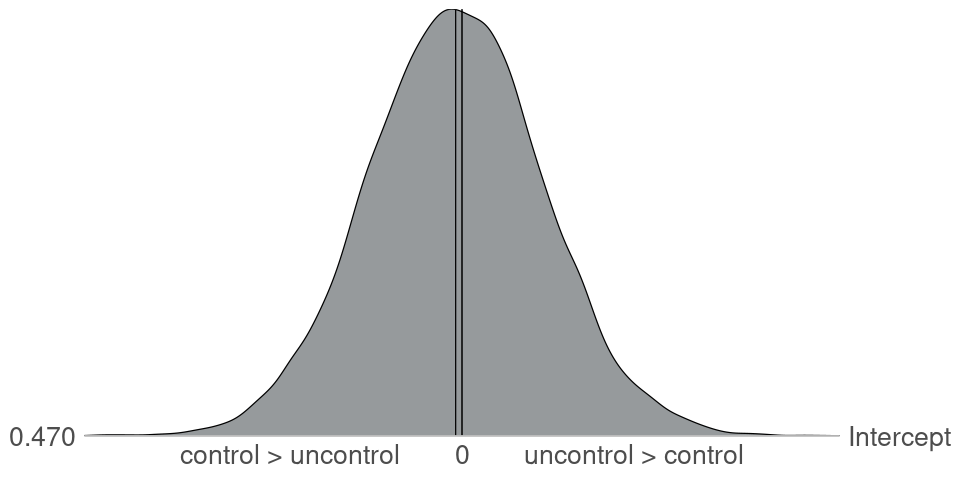

In [34]:
plotPDP(trait)

### Trait (uncon-con): Probability-Probability Plot

Warning message:
“Removed 12 rows containing non-finite values (stat_density).”


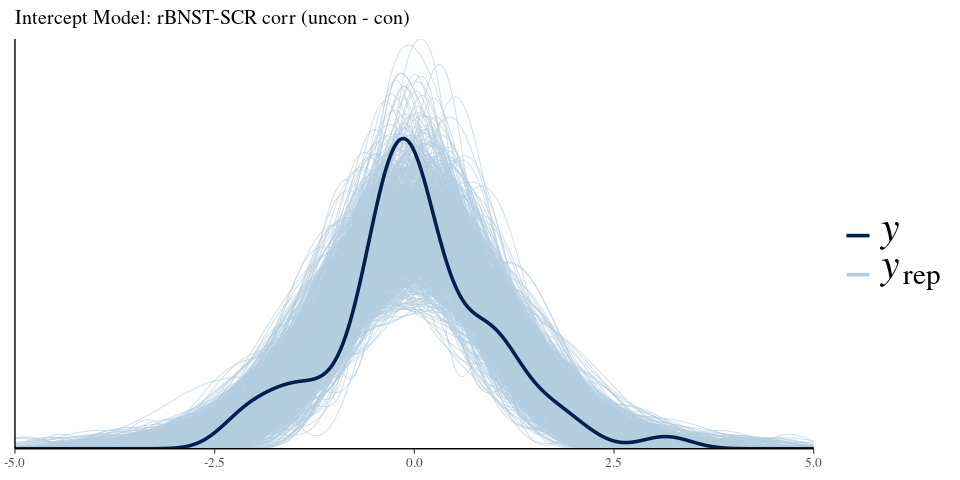

In [35]:
pp_plot = pp_check(trait,nsamples = 1000)

pp_plot + xlim(-5,5) + theme(text = element_text(size=10),legend.text=element_text(size=25)) + ggtitle("Intercept Model: Trait (uncon-con)",)

## **State (uncon-con)**

In [36]:
mod = '1'
modelForm = paste('STATEdiff ~',mod)
priorRBA <- get_prior(formula = modelForm,data=dataTable,family = 'student')
priorRBA$prior[2] <- "gamma(3.325,0.1)"
priorRBA

,prior,class,coef,group,resp,dpar,nlpar,bound
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,"student_t(3, 0, 10)",Intercept,,,,,,
2,"gamma(3.325,0.1)",nu,,,,,,
3,"student_t(3, 0, 10)",sigma,,,,,,


In [37]:
state <- brm(modelForm,
          data=dataTable,
          chains = chains,
          family = 'student',
          prior = priorRBA,
          inits=0, iter=iterations, 
          control = list(adapt_delta = 0.99, max_treedepth = 15))

Compiling the C++ model

recompiling to avoid crashing R session

Start sampling




SAMPLING FOR MODEL '204d3641dcffa1b885f9f2679fb9528e' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 10000 [  0%]  (Warmup)
Chain 1: Iteration: 1000 / 10000 [ 10%]  (Warmup)
Chain 1: Iteration: 2000 / 10000 [ 20%]  (Warmup)
Chain 1: Iteration: 3000 / 10000 [ 30%]  (Warmup)
Chain 1: Iteration: 4000 / 10000 [ 40%]  (Warmup)
Chain 1: Iteration: 5000 / 10000 [ 50%]  (Warmup)
Chain 1: Iteration: 5001 / 10000 [ 50%]  (Sampling)
Chain 1: Iteration: 6000 / 10000 [ 60%]  (Sampling)
Chain 1: Iteration: 7000 / 10000 [ 70%]  (Sampling)
Chain 1: Iteration: 8000 / 10000 [ 80%]  (Sampling)
Chain 1: Iteration: 9000 / 10000 [ 90%]  (Sampling)
Chain 1: Iteration: 10000 / 10000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.9 seconds (Warm-up)
Chain 1:                1.13 seconds (Sampling)
Chain

### State (uncon-con): Summary

In [38]:
summary(state)

 Family: student 
  Links: mu = identity; sigma = identity; nu = identity 
Formula: STATEdiff ~ 1 
   Data: dataTable (Number of observations: 61) 
Samples: 4 chains, each with iter = 10000; warmup = 5000; thin = 1;
         total post-warmup samples = 20000

Population-Level Effects: 
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept    -0.00      0.13    -0.25     0.25 1.00    12624    11114

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sigma     0.95      0.11     0.74     1.18 1.00     9100     7769
nu       27.16     16.77     5.35    68.42 1.00     9601     8204

Samples were drawn using sampling(NUTS). For each parameter, Bulk_ESS
and Tail_ESS are effective sample size measures, and Rhat is the potential
scale reduction factor on split chains (at convergence, Rhat = 1).

### State (uncon-con): Posteriors

Warning message in melt(data_trans, id = c("ROI", "X")):
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(data_trans). In the next version, this warning will become an error.”
Picking joint bandwidth of 0.0155

Warning message in min(x):
“no non-missing arguments to min; returning Inf”
Warning message in max(x):
“no non-missing arguments to max; returning -Inf”


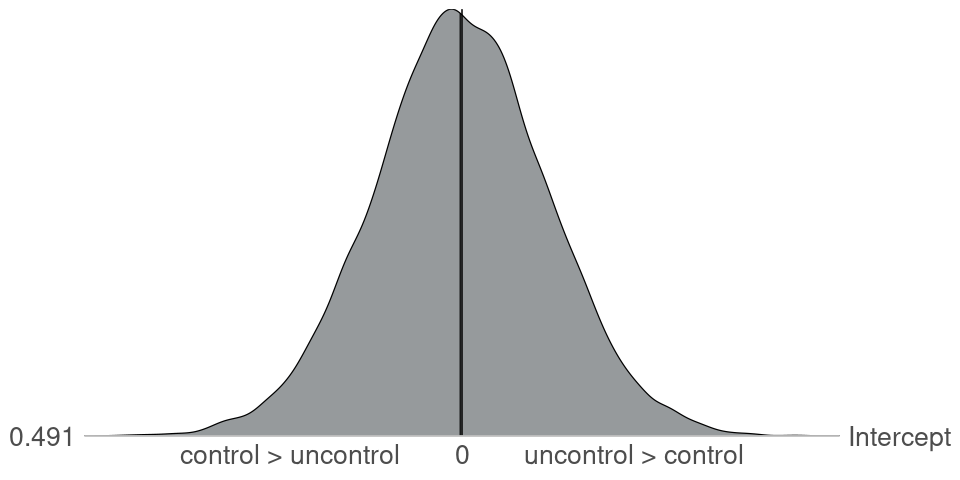

In [39]:
plotPDP(state)

### State difference: Probability-Probability Plot

Warning message:
“Removed 12 rows containing non-finite values (stat_density).”


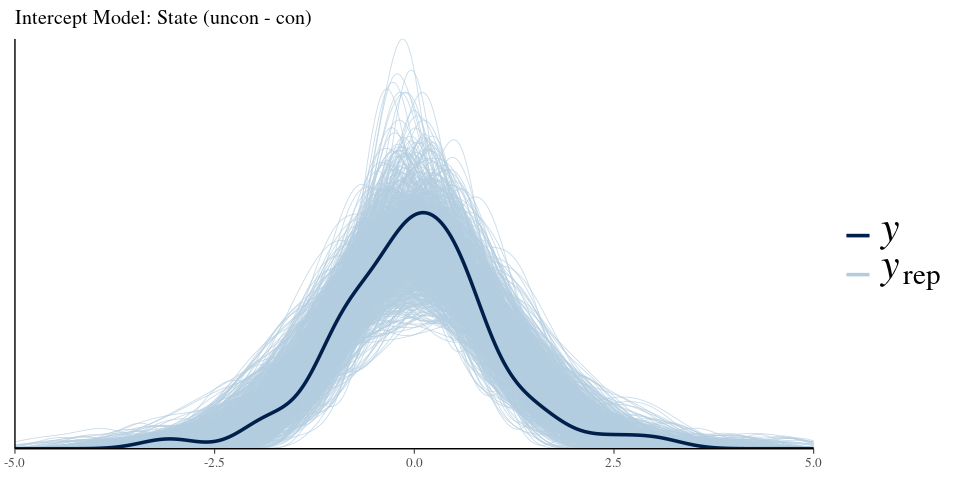

In [41]:
pp_plot = pp_check(state,nsamples = 1000)

pp_plot + xlim(-5,5) + theme(text = element_text(size=10),legend.text=element_text(size=25)) + ggtitle("Intercept Model: State (uncon - con)",)

In [28]:
getPosteriors <- function(model){
    data <- fixef(model,summary = FALSE)
}